In [ ]:
## import os
import sys
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.table import Table
from copy import deepcopy

In [2]:
cat = Table.read('jvds_stelkin_cat_v012_mge_v310820_private.fits', hdu=1)
df = cat.to_pandas()

headers_in = ["RE_CIRC_KPC", "MU_AT_RE", "LMSTAR", "SIGMA_RE", "GMINUSI", "MTYPE", "N_SERSIC"]

RE_CIRC_KPC:      FLOAT - Effective Circularised radius in KiloParsec from MGE (F. D'Eugenio in Prep.). \
MU_AT_RE:         FLOAT - Mean surface density at one Re from Bryant et al. 2015 \
LMSTAR:           FLOAT - Log_10 Stellar mass derived from g-i colour from Bryant et al. 2015 and Owers et al. 2017. \ \

GMINUSI:          FLOAT - g-i colour from from Bryant et al. 2015 and Owers et al. 2017. \
MTYPE:            FLOAT - SAMI visual morphological type from Cortese et al. 2016 \
N_SERSIC:         FLOAT - Sersic index from the GAMA best-fit 2D Sersic profile in the r-band Lee et al. 2012 (Concentration)

In [3]:
# Load in our mass radius, mtype and ID data
radius = cat.field('RE_CIRC_KPC')
density = cat.field("MU_AT_RE")
log_mass = cat.field('LMSTAR')
sigma = cat.field("SIGMA_RE")

colour = cat.field("GMINUSI")
mtype = cat.field("MTYPE")
sindex = cat.field("N_SERSIC")

In [4]:
# This is done in order to make the visualisation of the morphological types easier through a colorbar function 

mtype_old = deepcopy(mtype)
for i in range(len(mtype_old)):
    if mtype_old[i] == -9:
        mtype[i] = 6

---

## Lets explore the data and remove any outliers

In [5]:
data_vectors = [radius, density, log_mass, colour, mtype, sindex, sigma]
data_names = ["radius", "density", "log_mass", "colour", "mtype", "sindex", "sigma"]

/usr/local/anaconda3/envs/comp/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/anaconda3/envs/comp/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


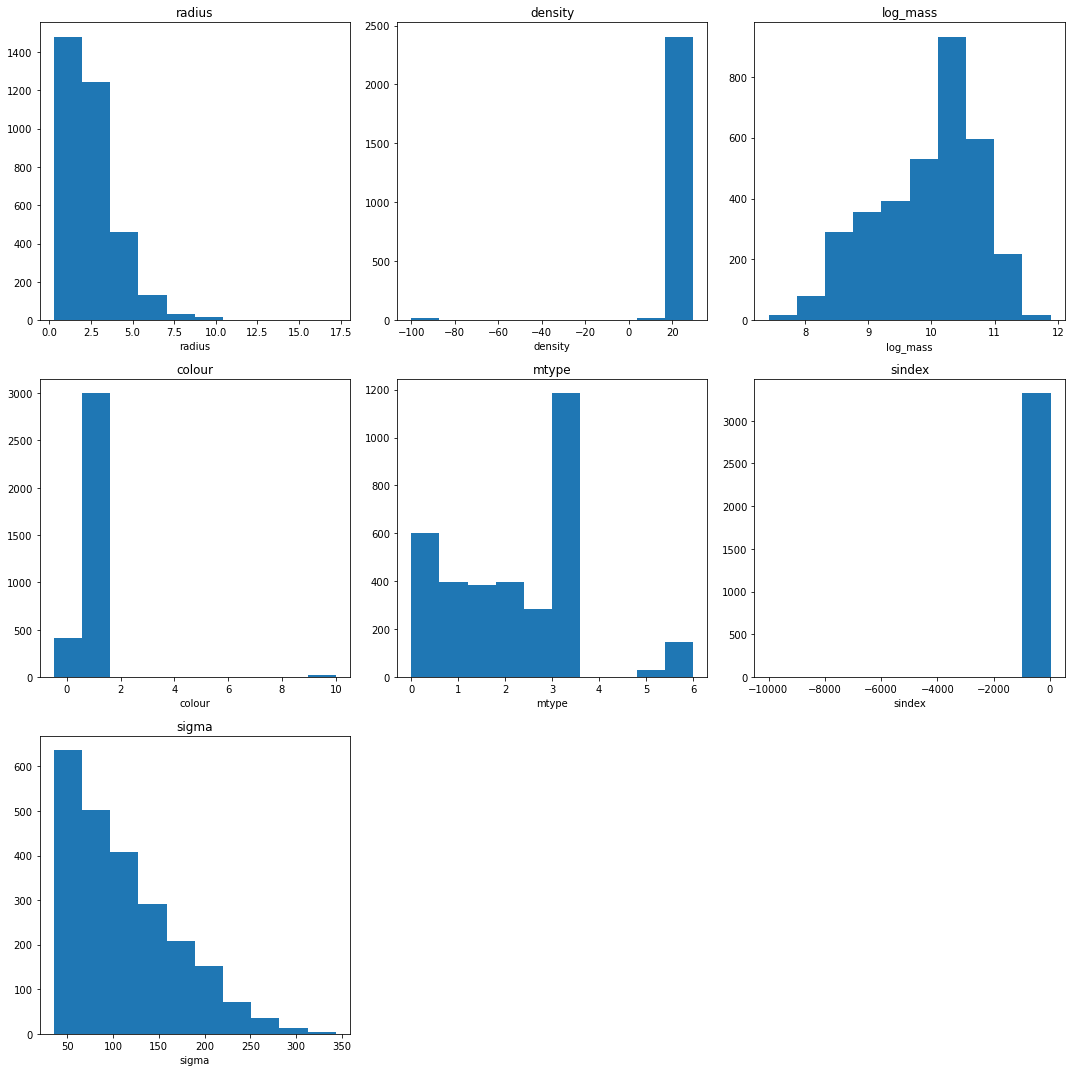

In [6]:
n = len(data_vectors)

plt.figure(figsize=(15, 15))

for i in range(n):
    plt.subplot(3, n//2, i+1)
    plt.hist(data_vectors[i])
    plt.title("{}".format(data_names[i]))
    plt.xlabel(data_names[i])
        
plt.tight_layout()

In [7]:
# Get rid of the crazy outliers, (some crazy sindex one, and the -9 and 5 entires of morphological type)
m1 = sindex > 0
m2 = mtype < 5
m3 = radius <= 10
m4 = (density <= 27.5)*(density >= 18)
m5 = (colour >= 0)*(colour <= 1.5)
m6 = sindex <= 8
mask_nan = np.logical_not(np.isnan(sigma))

/usr/local/anaconda3/envs/comp/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/usr/local/anaconda3/envs/comp/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(super(), op)(other)
/usr/local/anaconda3/envs/comp/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(super(), op)(other)


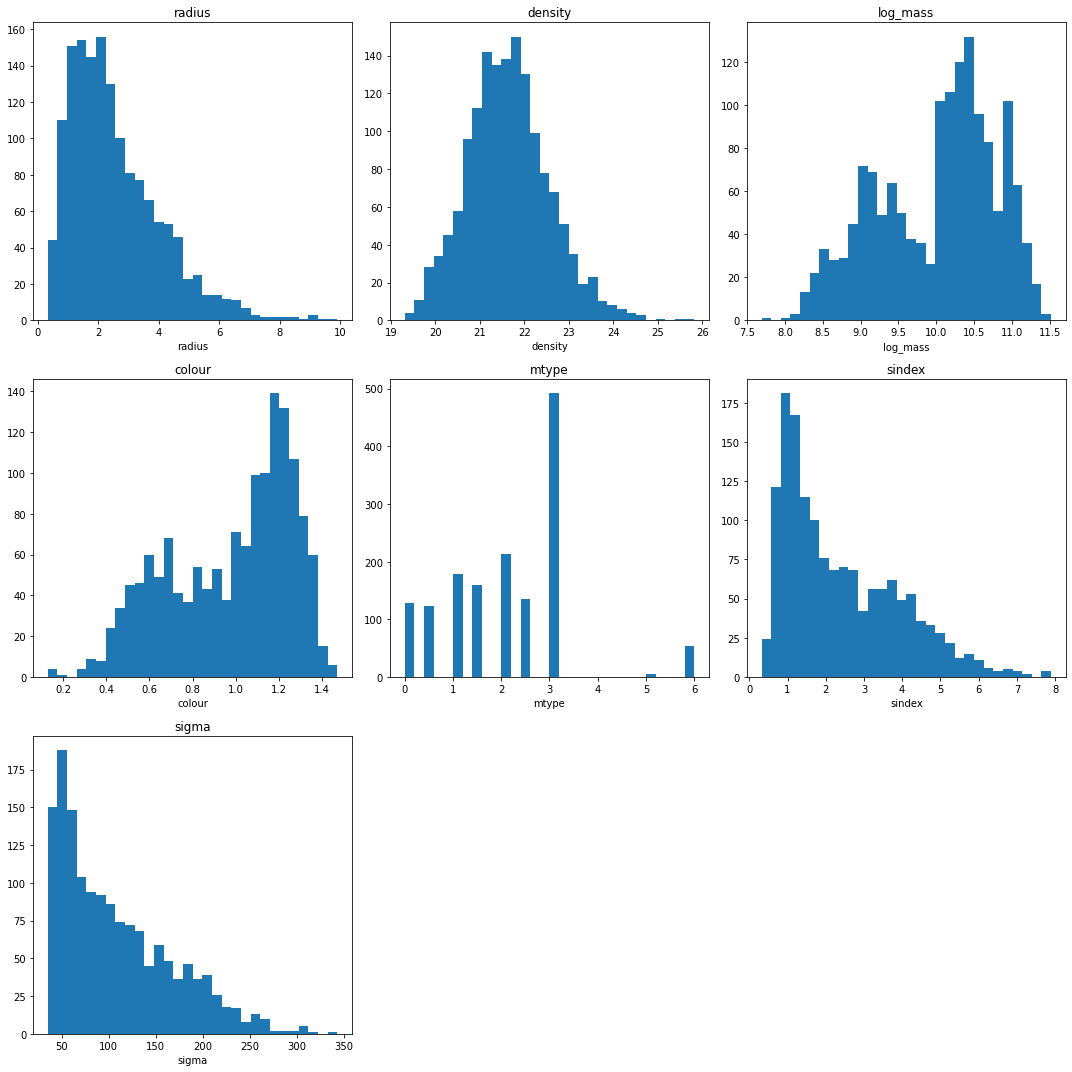

In [8]:
mask = m1*m3*m4*m5*m6*mask_nan

n = len(data_vectors)
plt.figure(figsize=(15, 15))

for i in range(n):
    plt.subplot(3, n//2, i+1)
    plt.hist(data_vectors[i][mask], bins=30)
    plt.title("{}".format(data_names[i]))
    plt.xlabel(data_names[i])
        
plt.tight_layout()

---
# Problem 1:
Fundamental plane parameters

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [10]:
def FPR(plane_params, data, sum_out=False):
    """
    Sum of squared error with manhatan distance from plane
    plane params should be coefficient1, coefficient2, intercept
    data should be [x, y, z]
    """
    diff = np.abs(plane_params[0]*data[0] + plane_params[1]*data[1] + plane_params[2] - data[2])
    if sum_out:
        return np.sum(diff**2)
    else:
        return diff**2

## We need to use some different masks here since the FP relation only applies to low mtype galaxies

In [11]:
# Only fit plane on low mtype
mask_train = mask*(mtype <= 1.5)
xvals = sigma[mask_train]
yvals = density[mask_train]
zvals = radius[mask_train]
col_val = colour[mask_train]

xvals -= np.median(xvals)
yvals -= np.median(yvals)
zvals -= np.median(zvals)
data = np.array([xvals, yvals, zvals])
print(data.shape)

##############
# All mtypes #
##############
xvals_all = sigma[mask]
yvals_all = density[mask]
zvals_all = radius[mask]
col_val_all = colour[mask]

xvals_all -= np.median(xvals_all)
yvals_all -= np.median(yvals_all)
zvals_all -= np.median(zvals_all)
data_all = np.array([xvals_all, yvals_all, zvals_all])
print(data_all.shape)

(3, 588)
(3, 1490)


In [12]:
lin = LinearRegression(normalize=True).fit(np.array(data[:2]).T, np.array(data[2]))
plane_params = [lin.coef_[0], lin.coef_[1], lin.intercept_]
distances = FPR(plane_params, data_all)

In [13]:
xs = np.linspace(np.min(data[0]), np.max(data[0]))
ys = np.linspace(np.min(data[1]), np.max(data[1]))  
X, Y = np.meshgrid(xs, ys)
Z = lin.coef_[0]*X + lin.coef_[1]*Y + lin.intercept_

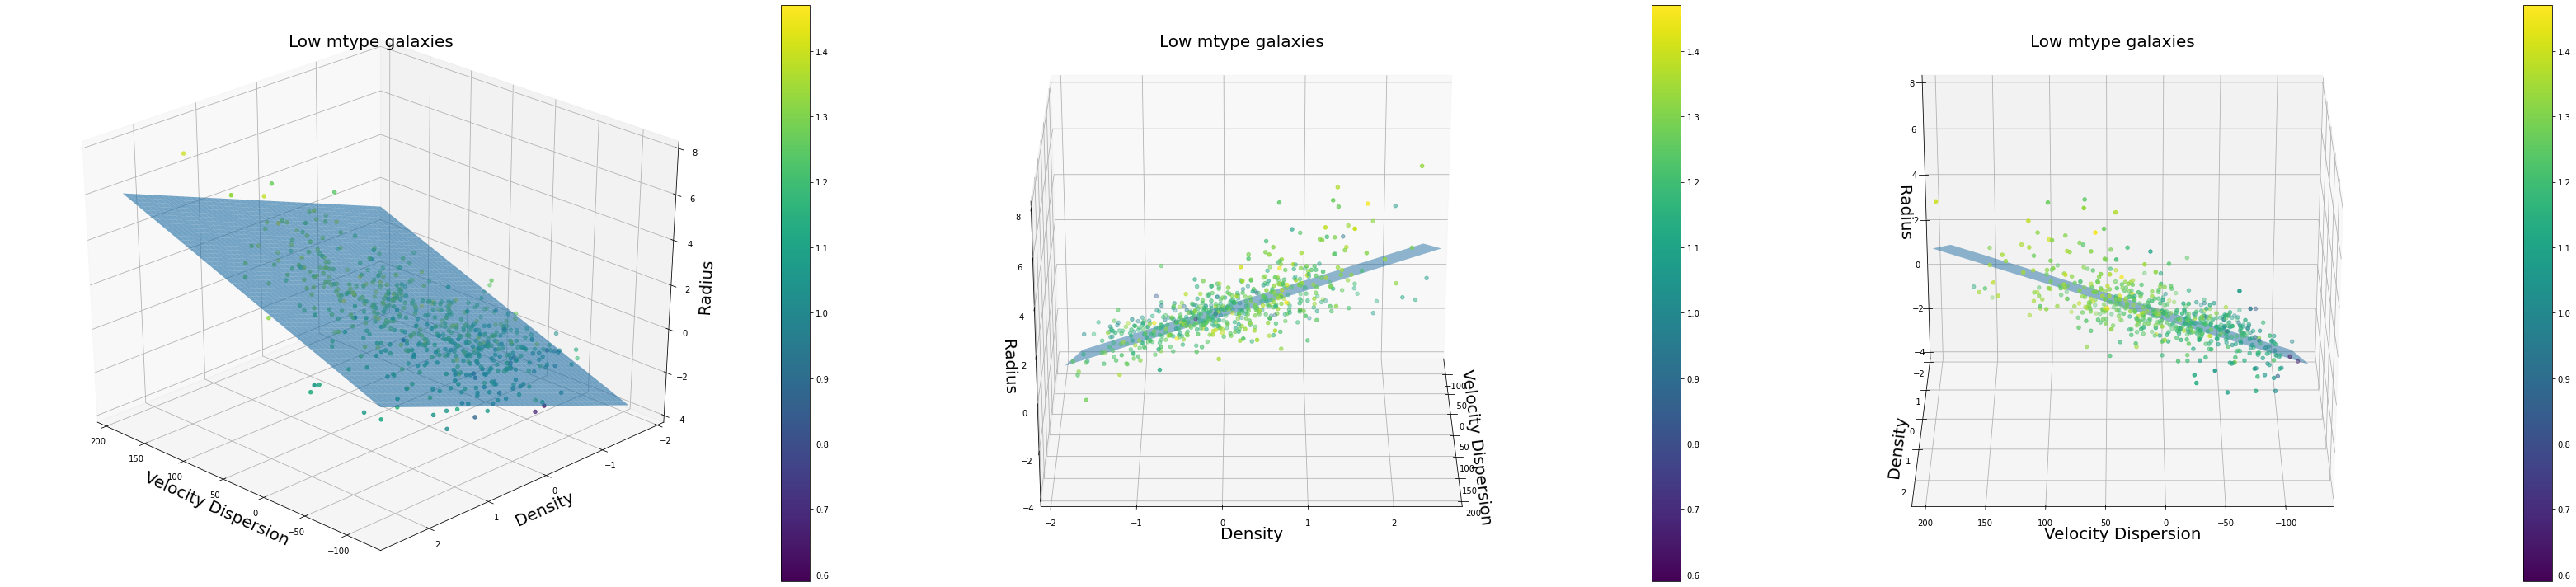

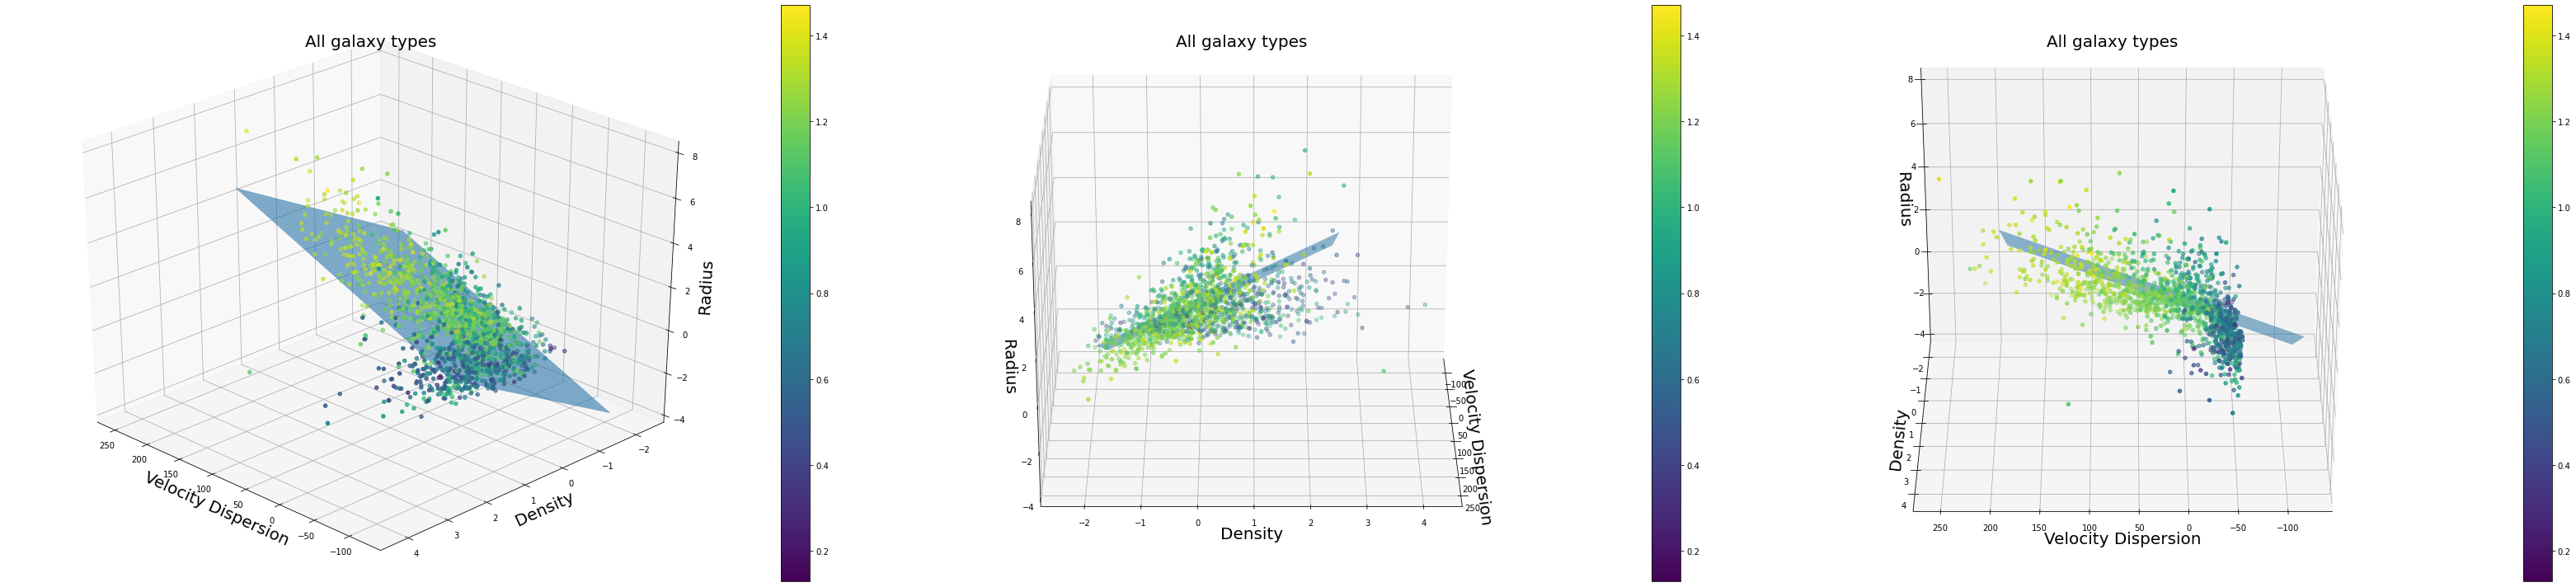

In [14]:
fig = plt.figure(figsize=(45,10))

ax = fig.add_subplot(131, projection='3d')
c = ax.scatter(data[0], data[1], data[2], c=col_val)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(30, 135)
plt.colorbar(c)
plt.title("Low mtype galaxies", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.set_xlabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

ax = fig.add_subplot(132, projection='3d')
c = ax.scatter(data[0], data[1], data[2], c=col_val)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(25, 0)
plt.colorbar(c)
plt.title("Low mtype galaxies", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.set_xlabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

ax = fig.add_subplot(133, projection='3d')
c = ax.scatter(data[0], data[1], data[2], c=col_val)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(25, 90)
plt.colorbar(c)
plt.title("Low mtype galaxies", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.set_xlabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(45,10))

ax = fig.add_subplot(131, projection='3d')
c = ax.scatter(data_all[0], data_all[1], data_all[2], c=col_val_all)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(30, 135)
plt.colorbar(c)
plt.title("All galaxy types", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.set_xlabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

ax = fig.add_subplot(132, projection='3d')
c = ax.scatter(data_all[0], data_all[1], data_all[2], c=col_val_all)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(25, 0)
plt.colorbar(c)
plt.title("All galaxy types", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.set_xlabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

ax = fig.add_subplot(133, projection='3d')
c = ax.scatter(data_all[0], data_all[1], data_all[2], c=col_val_all)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(30, 90)
plt.colorbar(c)
plt.title("All galaxy types", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.set_xlabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

plt.tight_layout()

---
# Problem 2:
Can the FP relation predict the other values?

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

In [16]:
X_names = ["Radius", "Sigma", "Density", "Distance"]
X_data_raw = np.array([radius[mask], sigma[mask], density[mask], distances]).T

Y_names = ["Log Mass", "Mtype", "Colour", "S index"]
Y_data_raw = np.array([log_mass[mask], mtype[mask], colour[mask], sindex[mask]]).T

# Create the holdout data, keep random state of zero
X_data, X_data_holdout, Y_data, Y_data_holdout = train_test_split(X_data_raw, Y_data_raw, test_size=0.3, random_state=0)
Y_data, Y_data_holdout = list(Y_data.T), list(Y_data_holdout.T)

In [17]:
Ntest = 10
params = {
    'max_depth': np.arange(5, 15),
    'splitter': ["best", "random"]
        }

best_DTs = []
for i in range(len(Y_data)):
    depths = []
    splitters = []
    for r in range(Ntest):
        X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data[i], test_size=0.25, random_state=r)
        cv = GridSearchCV(DecisionTreeRegressor(), params).fit(X_train, Y_train)
        depths.append(cv.best_params_['max_depth'])
        splitters.append(cv.best_params_['splitter'])

    best_depth = np.round(np.average(depths), decimals=0).astype(np.int16)
    best_splitter = max(set(splitters), key=splitters.count)
    best_DTs.append(DecisionTreeRegressor(max_depth=best_depth, splitter=best_splitter))
    print(best_depth, best_splitter)

8 best
5 random
6 random
6 best


In [18]:
%%time
Ntest = 10
params = {
    'n_estimators': np.arange(10, 20, 2),
    'bootstrap': [True, False]
        }

best_BGs = []
for i in range(len(Y_data)):
    n_ests = []
    bootstraps = []
    for r in range(Ntest):
        X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data[i], test_size=0.25, random_state=r)
        cv = GridSearchCV(BaggingRegressor(), params).fit(X_train, Y_train)
        n_ests.append(cv.best_params_['n_estimators'])
        bootstraps.append(cv.best_params_['bootstrap'])

    best_n_est = np.round(np.average(n_ests), decimals=0).astype(np.int16)
    best_bootstrap = max(set(bootstraps), key=bootstraps.count)
    best_BGs.append(BaggingRegressor(n_estimators=best_n_est, bootstrap=best_bootstrap))
    print(best_n_est, best_bootstrap)

14 True
15 True
16 True
15 True
CPU times: user 1min 15s, sys: 1.18 s, total: 1min 17s
Wall time: 1min 19s


In [ ]:
%%time
Ntest = 10
params = {
    'n_estimators': np.arange(75, 175, 25),
    'max_depth': np.arange(5, 18, 3)
        }

best_RFs = []
for i in range(len(Y_data)):
    n_ests = []
    depths = []
    for r in range(Ntest):
        X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data[i], test_size=0.25, random_state=r)
        cv = GridSearchCV(RandomForestRegressor(), params).fit(X_train, Y_train)
        n_ests.append(cv.best_params_['n_estimators'])
        depths.append(cv.best_params_['max_depth'])

    best_n_est = np.round(np.average(n_ests), decimals=0).astype(np.int16)
    best_depth = np.round(np.average(depths), decimals=0).astype(np.int16)
    best_RFs.append(RandomForestRegressor(n_estimators=best_n_est, max_depth=best_depth))
    print(best_n_est, best_depth)

In [ ]:
predictors = [best_DTs, best_BGs, best_RFs]
pred_names = ["DT", "BG", "RF"]
cols = ['tab:blue', 'tab:orange', 'tab:green']

In [ ]:
for i in range(len(Y_data)):
    plt.figure(figsize=(24, 6))
    trained = []
    for j in range(len(predictors)):
        trained.append(predictors[j][i].fit(X_data, Y_data[i]))
        
    plt.subplot(1, 2, 1)
    for j in range(len(predictors)):
        Rsq = 100*r2_score(Y_data_holdout[i], trained[j].predict(X_data_holdout))
        plt.scatter(Y_data_holdout[i], trained[j].predict(X_data_holdout), c=cols[j], label="{}: {:.0f}".format(pred_names[j], Rsq), alpha=0.75) 
    xs = np.linspace(np.min(Y_data_holdout[i]), np.max(Y_data_holdout[i]))
    plt.plot(xs, xs, alpha=0.5, c='k')
    plt.legend(fontsize=20)
    plt.title(Y_names[i], fontsize=30)
    plt.xlabel("True value", fontsize=25)
    plt.ylabel("Predicted value", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.subplot(1, 2, 2)
    for j in range(len(predictors)):
        Rsq = 100*r2_score(Y_data_holdout[i], trained[j].predict(X_data_holdout))
        plt.scatter(Y_data_holdout[i], Y_data_holdout[i] - trained[j].predict(X_data_holdout), c=cols[j], label="{}: {:.0f}".format(pred_names[j], Rsq), alpha=0.75) 
        
    plt.axhline(0, c='k', alpha=0.5)
    plt.legend(fontsize=20)
    plt.title(Y_names[i], fontsize=30)
    plt.xlabel("True value", fontsize=25)
    plt.ylabel("Error", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig("test {}".format(i))

---
# Problem 3:
How related are each of the parameters? Show weightings and predictability of each one

In [ ]:
names = ["Radius", "Sigma", "Density", "Distance", "Log Mass", "Mtype", "Colour", "S index"]
cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink', 'tab:cyan', 'tab:olive']
data_raw = np.array([radius[mask], sigma[mask], density[mask], distances, log_mass[mask], mtype[mask], colour[mask], sindex[mask]]).T

# Create the holdout data, keep random state of zero
data, data_holdout = train_test_split(data_raw, test_size=0.3, random_state=0)
data, data_holdout = list(data.T), list(data_holdout.T)

In [ ]:
%%time
Ntest = 10
params = {
    'max_depth': np.arange(5, 15),
    'splitter': ["best", "random"]
        }

best_DTs = []
for i in range(len(data)):
    # Construct data so its formatted approriately
    Y_data = data[i]
    X_data = np.array(data[:i] + data[i+1:]).T

    n_ests = []
    bootstraps = []
    for r in range(Ntest):
        X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.25, random_state=r)
        cv = GridSearchCV(DecisionTreeRegressor(), params).fit(X_train, Y_train)
        depths.append(cv.best_params_['max_depth'])
        splitters.append(cv.best_params_['splitter'])

    best_depth = np.round(np.average(depths), decimals=0).astype(np.int16)
    best_splitter = max(set(splitters), key=splitters.count)
    best_DTs.append(DecisionTreeRegressor(max_depth=best_depth, splitter=best_splitter))
    print(best_depth, best_splitter)

In [ ]:
# Bootstrap doesnt have weighting so no need to use it
# %%time
# Ntest = 5
# params = {
#     'n_estimators': np.arange(10, 20, 2),
#     'bootstrap': [True, False]
#         }

# best_BGs = []
# for i in range(len(data)):
#     Y_data = data[i]
#     X_data = np.array(data[:i] + data[i+1:]).T

#     n_ests = []
#     bootstraps = []
#     for r in range(Ntest):
#         X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.25, random_state=r)
#         cv = GridSearchCV(BaggingRegressor(), params).fit(X_train, Y_train)
#         n_ests.append(cv.best_params_['n_estimators'])
#         bootstraps.append(cv.best_params_['bootstrap'])

#     best_n_est = np.round(np.average(n_ests), decimals=0).astype(np.int16)
#     best_bootstrap = max(set(bootstraps), key=bootstraps.count)
#     best_BGs.append(BaggingRegressor(n_estimators=best_n_est, bootstrap=best_bootstrap))
#     print(best_n_est, best_bootstrap)

In [ ]:
%%time
Ntest = 10
params = {
    'n_estimators': np.arange(75, 150, 25),
    'max_depth': np.arange(5, 18, 3)
        }

best_RFs = []
for i in range(len(data)):
    Y_data = data[i]
    X_data = np.array(data[:i] + data[i+1:]).T
    n_ests = []
    depths = []
    for r in range(Ntest):
        X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.25, random_state=r)
        cv = GridSearchCV(RandomForestRegressor(), params).fit(X_train, Y_train)
        n_ests.append(cv.best_params_['n_estimators'])
        depths.append(cv.best_params_['max_depth'])

    best_n_est = np.round(np.average(n_ests), decimals=0).astype(np.int16)
    best_depth = np.round(np.average(depths), decimals=0).astype(np.int16)
    best_RFs.append(RandomForestRegressor(n_estimators=best_n_est, max_depth=best_depth))
    print(best_n_est, best_depth)

In [ ]:
classifiers = [best_DTs, best_RFs]
classifier_names = ["DT", "RF"]

In [ ]:
plt.figure(figsize=(24, 10))

for j in range(len(classifiers)):
    squares = np.ones([len(names), len(names)])
    name_weights = []    
    for i in range(len(data)):
        Y_data = data[i]
        X_data = np.array(data[:i] + data[i+1:]).T
        Y_data_holdout = data_holdout[i]
        X_data_holdout = np.array(data_holdout[:i] + data_holdout[i+1:]).T
        Y_name = names[i]
        X_names = names[:i] + names[i+1:]

        # Make classifer
        classifier = classifiers[j][i].fit(X_data, Y_data)
        Rsq = r2_score(Y_data_holdout, classifier.predict(X_data_holdout))
        weights = Rsq*classifier.feature_importances_
        name_weights.append("{}: {:.0f}".format(Y_name, 100*Rsq))

        # Generate correlations
        squares[i, :i] = weights[:i]
        squares[i, i+1:] = weights[i:]
        
#         # Print values for checking
#         print("{}:   {:.2f}".format(Y_name, Rsq))
#         for k in range(len(X_names)):
#             print("    {}:\t{:.2f}".format(X_names[k], classifier.feature_importances_[k]))
#         print('\n')

    plt.subplot(1, 2, j+1)
    plt.imshow(squares, cmap='hot')
    plt.xticks(np.arange(len(names)), names, fontsize=15, rotation=25)
    plt.yticks(np.arange(len(names)), name_weights, fontsize=15)
    plt.title("{}: {:.2f}".format(classifier_names[j], np.sum(squares)-8), fontsize=25)
    plt.ylabel("Predicted Parameter", fontsize=20)
    plt.xlabel("Parameter Weighting", fontsize=20)
    plt.colorbar()
plt.tight_layout()
plt.savefig("Best Fig")
plt.show()